In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import json
import os
from PIL import Image
import numpy as np
from tqdm import tqdm

# Check if GPU available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load labels
with open('data/train_labels.json', 'r') as f:
    train_labels = json.load(f)
with open('data/val_labels.json', 'r') as f:
    val_labels = json.load(f)
with open('data/test_labels.json', 'r') as f:
    test_labels = json.load(f)

# Create custom dataset
class KidneyDataset(Dataset):
    def __init__(self, labels_list, data_dir, transform=None):
        self.labels_list = labels_list
        self.data_dir = data_dir
        self.transform = transform
        
        # Create label mapping
        self.label_to_idx = {'kidney_normal': 0, 'kidney_tumor': 1}
    
    def __len__(self):
        return len(self.labels_list)
    
    def __getitem__(self, idx):
        item = self.labels_list[idx]
        img_path = os.path.join(self.data_dir, item['filename'])
        image = Image.open(img_path).convert('RGB')
        label = self.label_to_idx[item['label']]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Data transforms
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

# Create datasets and dataloaders
train_dataset = KidneyDataset(train_labels, 'data/train', train_transform)
val_dataset = KidneyDataset(val_labels, 'data/val', val_transform)
test_dataset = KidneyDataset(test_labels, 'data/test', val_transform)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

# Load ResNet-18 model
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(512, 2)  # 2 classes: normal, tumor
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

print("\nModel loaded. Ready for training!")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

Using device: cpu
Train batches: 219
Val batches: 47
Test batches: 47
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/Sajjan/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


/home/Sajjan/Desktop/ML_Practice/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/Sajjan/Desktop/ML_Practice/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 44.7M/44.7M [00:00<00:00, 75.7MB/s]



Model loaded. Ready for training!
Total parameters: 11,177,538


In [2]:
# Training function
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for images, labels in tqdm(train_loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    
    avg_loss = total_loss / len(train_loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

# Validation function
def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    avg_loss = total_loss / len(val_loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

# Train for 10 epochs
num_epochs = 10
best_val_acc = 0
patience = 3
patience_counter = 0

os.makedirs('checkpoints', exist_ok=True)

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    scheduler.step()
    
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'checkpoints/best_model.pth')
        patience_counter = 0
        print(f"  ✓ Best model saved (Val Acc: {val_acc:.2f}%)")
    else:
        patience_counter += 1
    
    # Early stopping
    if patience_counter >= patience:
        print(f"  Early stopping at epoch {epoch+1}")
        break

print(f"\nTraining complete! Best Val Accuracy: {best_val_acc:.2f}%")

Validating: 100%|██████████| 47/47 [00:11<00:00,  3.95it/s]



Epoch 1/10
  Train Loss: 0.1477, Train Acc: 94.57%
  Val Loss: 1.0951, Val Acc: 70.87%
  ✓ Best model saved (Val Acc: 70.87%)


Validating: 100%|██████████| 47/47 [00:11<00:00,  4.06it/s]



Epoch 2/10
  Train Loss: 0.0513, Train Acc: 98.11%
  Val Loss: 0.1498, Val Acc: 93.80%
  ✓ Best model saved (Val Acc: 93.80%)


Validating: 100%|██████████| 47/47 [00:11<00:00,  4.09it/s]



Epoch 3/10
  Train Loss: 0.0521, Train Acc: 98.10%
  Val Loss: 0.1348, Val Acc: 95.00%
  ✓ Best model saved (Val Acc: 95.00%)


Validating: 100%|██████████| 47/47 [00:11<00:00,  4.14it/s]



Epoch 4/10
  Train Loss: 0.0243, Train Acc: 99.23%
  Val Loss: 0.0090, Val Acc: 99.73%
  ✓ Best model saved (Val Acc: 99.73%)


Validating: 100%|██████████| 47/47 [00:11<00:00,  4.15it/s]



Epoch 5/10
  Train Loss: 0.0254, Train Acc: 99.17%
  Val Loss: 0.0038, Val Acc: 99.87%
  ✓ Best model saved (Val Acc: 99.87%)


Validating: 100%|██████████| 47/47 [00:12<00:00,  3.91it/s]



Epoch 6/10
  Train Loss: 0.0059, Train Acc: 99.80%
  Val Loss: 0.0004, Val Acc: 100.00%
  ✓ Best model saved (Val Acc: 100.00%)


Validating: 100%|██████████| 47/47 [00:11<00:00,  4.20it/s]



Epoch 7/10
  Train Loss: 0.0022, Train Acc: 99.97%
  Val Loss: 0.0002, Val Acc: 100.00%


Validating: 100%|██████████| 47/47 [00:11<00:00,  4.04it/s]



Epoch 8/10
  Train Loss: 0.0019, Train Acc: 99.94%
  Val Loss: 0.0001, Val Acc: 100.00%


Validating: 100%|██████████| 47/47 [00:11<00:00,  4.14it/s]


Epoch 9/10
  Train Loss: 0.0013, Train Acc: 99.97%
  Val Loss: 0.0001, Val Acc: 100.00%
  Early stopping at epoch 9

Training complete! Best Val Accuracy: 100.00%


Testing: 100%|██████████| 47/47 [00:11<00:00,  4.15it/s]


TEST SET METRICS
Accuracy:  0.9993
Precision: 1.0000
Recall:    0.9987
F1-Score:  0.9993
ROC-AUC:   1.0000

Confusion Matrix:
  True Negatives:  734
  False Positives: 0
  False Negatives: 1
  True Positives:  765


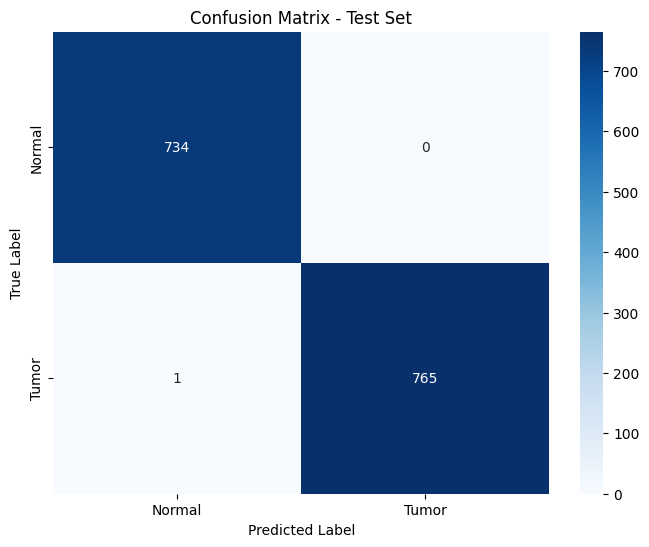

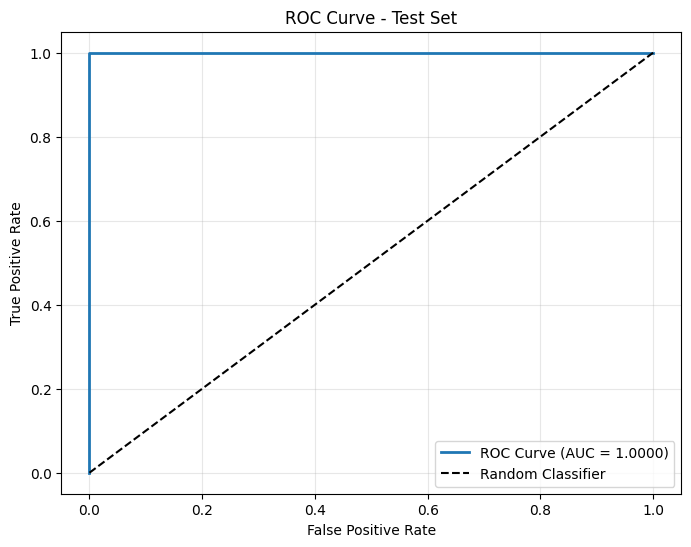


✓ Test evaluation complete!


In [3]:
# Load best model
model.load_state_dict(torch.load('checkpoints/best_model.pth'))

# Test function
def test_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    return np.array(all_preds), np.array(all_labels), np.array(all_probs)

# Run test
test_preds, test_labels, test_probs = test_model(model, test_loader, device)

# Calculate metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt

test_acc = accuracy_score(test_labels, test_preds)
test_precision = precision_score(test_labels, test_preds)
test_recall = recall_score(test_labels, test_preds)
test_f1 = f1_score(test_labels, test_preds)
test_auc = roc_auc_score(test_labels, test_probs[:, 1])

print("=" * 50)
print("TEST SET METRICS")
print("=" * 50)
print(f"Accuracy:  {test_acc:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall:    {test_recall:.4f}")
print(f"F1-Score:  {test_f1:.4f}")
print(f"ROC-AUC:   {test_auc:.4f}")

# Confusion matrix
cm = confusion_matrix(test_labels, test_preds)
print(f"\nConfusion Matrix:")
print(f"  True Negatives:  {cm[0,0]}")
print(f"  False Positives: {cm[0,1]}")
print(f"  False Negatives: {cm[1,0]}")
print(f"  True Positives:  {cm[1,1]}")

# Plot confusion matrix
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Tumor'], 
            yticklabels=['Normal', 'Tumor'])
plt.title('Confusion Matrix - Test Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Plot ROC curve
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(test_labels, test_probs[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {test_auc:.4f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Test Set')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print("\n✓ Test evaluation complete!")